# Problem

You are given a training data set $\{x_n , t_n \}$ of size N = 21. Each input vector $x_n$ is a point in the 2-dimensional Euclidean space $R^2$ . We have $x_1 = (0, 0), x_2 = (1, 0), x_3 = (2, 0), x_4 = (0, 1), x_5 = (1, 1), x_6 = (2, 1), x_7 = (3, 1), x_8 = (4, 1), x_9 = (5, 1), x_{10} = (100, 1), x_{11} = (0, 2), x_{12} = (1, 2), x_{13} = (2, 2), x_{14} = (3, 2), x_{15} = (4, 2), x_{16} = (5, 2), x_{17} = (100, 2), x_{18} = (3, 3), x_{19} = (4, 3), x_{20} = (5, 3), x_{21} = (100, 3)$

There are two target classes C1 and C2. For each point $x_n$ in the training set, $x_n$ belongs to C1 if its second coordinate is less than or equal to 2, and belongs to C2 otherwise. If $x_n \in C1$, we have $t_n = 1$. If $x_n \in C2$, we have $t_n = 0$ in the questions regarding least squares linear discriminant and Fisher's linear discriminant, and have $t_n = -1$ in the question on the perceptron algorithm

## Load the dataset

In [228]:
import numpy as np
from sklearn import preprocessing

def x2lable(x, is_for_perceptron=False):
    """will return a list of (x, t)"""
    t_data = []
    for item in x:
        t = 1
        if item[1] > 2:
            if is_for_perceptron:
                t = -1
            else:
                t = 0
        t_data.append(t)
    return np.array(t_data)

def load_data():
    x_train = np.array([[0,0],[1,0],[2,0],[0,1],[1,1],[2,1],[3,1],[4,1],[5,1],[100,1],[0,2],[1,2],[2,2],[3,2],[4,2],[5,2],[100,2],[3,3],[4,3],[5,3],[100,3]])
    n_data = x_train.shape[0]
    bias = np.ones((n_data, 1))
    x_train_with_bias = np.append(bias, x_train, axis=1)
    
    c1_data = []
    c2_data = []
    
    labels_square_fisher = x2lable(x_train, False)
    labels_perceptron = x2lable(x_train, True)
    for i in range(0, len(x_train)):
        if labels_perceptron[i] == 1:
            c1_data.append(x_train[i])
        else:
            c2_data.append(x_train[i])
            
    
    return [[x_train_with_bias, labels_square_fisher], [x_train_with_bias, labels_perceptron], np.array(c1_data), np.array(c2_data)]

data = load_data()
least_squares_data = data[0]
fisher_data = data[0]
perceptron_data = data[1]
c1_data = data[2]
c2_data = data[3]

print('Shape of traning data: ', data[0][0].shape)
print('Shape of traning labels: ', data[0][1].shape)
print('Shape of c1 data: ', c1_data.shape)
print('Shape of c2 data: ', c2_data.shape)

Shape of traning data:  (21, 3)
Shape of traning labels:  (21,)
Shape of c1 data:  (17, 2)
Shape of c2 data:  (4, 2)


## Least-Square Linear Classifier
Compute the least-square linear classifier based on the training data. You need to write out (a) the error function, (b) the computed parameters $(w_0 , w_1 , w_2)$, and (c) plot the classification together with the training data

### Calcualte the weights

In matrix form:
$w = (X^T X)^{-1} X^T Y$

In [157]:
def w_calc_least_square(x_train_with_bias, y_train):
    # generate the T matrix
    T = np.zeros((x_train_with_bias.shape[0], 2))
    for i in range(0, len(y_train)):
        if y_train[i] == 1:
            T[i][0] = 1
        else:
            T[i][1] = 1
    # calculate the weights
    weights = np.linalg.inv(np.dot(x_train_with_bias.T, x_train_with_bias))
    weights = np.dot(np.dot(weights, x_train_with_bias.T), T)
    
    print('Shape of T matrix: ', T.shape)
    print('Shape of x_train_with_bias:', x_train_with_bias.shape)
    print('Shape of y_train:', y_train.shape)
    print('Shape of weights:', weights.shape)
    
    return weights

def solve_least_square():
    x_train = least_squares_data[0]
    y_train = least_squares_data[1]
 
    weights = w_calc_least_square(x_train, y_train)
    print('Learned weights:', weights)
    
    # test the accuracy
    prediction =  np.dot(weights.T, x_train.T)
    n_test = len(y_train)
    n_correct = 0
    for i in range(0, n_test):
        t = 1
        if prediction[0][i] < prediction[1][i]:
            t = 0
        if t == y_train[i]:
            n_correct += 1
    
    print('Prediction accuracy on training set: %.2f%%' % (float(n_correct)/n_test*100))
    return weights

w_least_square = solve_least_square()

Shape of T matrix:  (21, 2)
Shape of x_train_with_bias: (21, 3)
Shape of y_train: (21,)
Shape of weights: (3, 2)
Learned weights: [[ 1.27964245e+00 -2.79642450e-01]
 [-2.05868000e-04  2.05868000e-04]
 [-2.97014152e-01  2.97014152e-01]]
Prediction accuracy on training set: 100.00%


#### We can also solve it using gradient descent

In [156]:
def loss_least_square(w, x, y):
    n_data = len(x)
    delta = y - np.dot(x, w)
    return np.sum(np.square(delta))/(2*n_data)

def w_calc_least_square_gradient(x_train_with_bias, y_train, epsilon = 0.0000001, learning_rate = 0.001):
    n_data = x_train_with_bias.shape[0]
    weights = np.zeros((3, ))
    
    i = 0
    old_loss_value = 0
    loss_value = 0
    while i == 0 or abs(old_loss_value - loss_value) > epsilon:
        
        old_loss_value = loss_value
        i+=1
        if i == 1000000:
            print('Fail to converge in %d iteration' % (i))
            break
        
        delta = np.dot(x_train_with_bias, weights) - y_train
        partial_derivative = (1.0/n_data)*np.dot(x_train_with_bias.T, delta)
        # update weights
        weights = weights - partial_derivative*learning_rate
        
        loss_value = loss_least_square(weights, x_train_with_bias, y_train)
        
    return weights

def solve_least_square_gradient_descent():
    x_train = least_squares_data[0]
    y_train_c1 = least_squares_data[1]
    # generate y_train_c1
    y_train_c2 = np.zeros(y_train_c1.shape)
    for i in range(0, len(y_train_c1)):
        y_train_c2[i] = abs(y_train_c1[i] - 1)
    
    w_least_square_c1 = w_calc_least_square_gradient(x_train, y_train_c1)
    print('Learned weights of classifier 1:', w_least_square_c1)
    print('Final loss: ', loss_least_square(w_least_square_c1, x_train, y_train_c1))
    
    w_least_square_c2 = w_calc_least_square_gradient(x_train, y_train_c2)
    print('Learned weights of classifier 2:', w_least_square_c2)
    print('Final loss: ', loss_least_square(w_least_square_c2, x_train, y_train_c2))
    
    return (w_least_square_c1, w_least_square_c2)

w_least_square_gradient_descent = solve_least_square_gradient_descent()

Learned weights of classifier 1: [ 1.23870348e+00 -1.94278070e-04 -2.76787444e-01]
Final loss:  0.03668881434713212
Learned weights of classifier 2: [-2.38707891e-01  1.94279319e-04  2.76789623e-01]
Final loss:  0.036688765151482235


### Visualize the Results (Least-Square)

In [160]:
import matplotlib.pyplot as plt
# visualize data points
def visualize_data(x_data, y_data):
    c1_data_index = []
    c2_data_index = []
    
    for i in range(0, x_data.shape[0]):
        if y_data[i] == 1:
            c1_data_index.append(i)
        else:
            c2_data_index.append(i)
    
    # use red dot to represent C1
    plt.plot([x_data[c1_data_index[i]][1] for i in range(0, len(c1_data_index))], [x_data[c1_data_index[i]][2] for i in range(0, len(c1_data_index))], 'rx')
    
    # use blue dot to represent C2
    plt.plot([x_data[c2_data_index[i]][1] for i in range(0, len(c2_data_index))], [x_data[c2_data_index[i]][2] for i in range(0, len(c2_data_index))], 'bx')
    
    plt.xlabel('x0')
    plt.ylabel('x1')

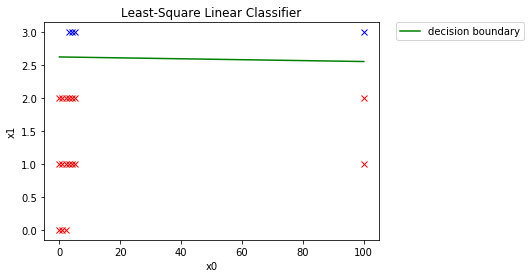

In [151]:
def visualize_decision_boundary_least_square(weights1, weights2, x0_min=0, x0_max=100, color='r', label='decision boundary'):
    w10 = weights1[0]
    w11 = weights1[1]
    w12 = weights1[2]
    
    w20 = weights2[0]
    w21 = weights2[1]
    w22 = weights2[2]
    
    # the decision boundary is where w10 + w11*x0 + w12*x1 = w20 + w21*x0 + w22*x1
    # which satisfies x1 = (w21 - w11)/(w12 - w22)*x0 + (w20 - w10)/(w12 - w22)
    
    x10 = (w21 - w11)/(w12 - w22)*x0_min + (w20 - w10)/(w12 - w22)
    x11 = (w21 - w11)/(w12 - w22)*x0_max + (w20 - w10)/(w12 - w22)
    plt.plot([x0_min, x0_max], [x10, x11], color, label=label) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
def visualize_least_square():
    visualize_data(least_squares_data[0], least_squares_data[1])
    w1 = w_least_square.T[0]
    w2 = w_least_square.T[1]
    visualize_decision_boundary_least_square(w1, w2, color='g')
    plt.title('Least-Square Linear Classifier')

visualize_least_square()

#### Results learned by gradient descent

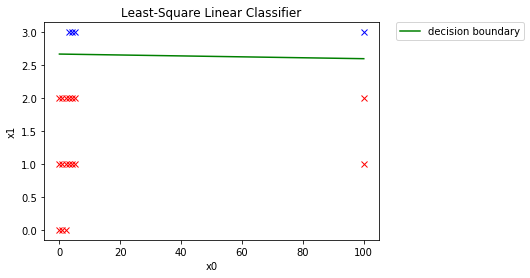

In [161]:
def visualize_least_square_gradient():
    visualize_data(least_squares_data[0], least_squares_data[1])
    w1 = w_least_square_gradient_descent[0]
    w2 = w_least_square_gradient_descent[1]
    visualize_decision_boundary_least_square(w1, w2, color='g')
    plt.title('Least-Square Linear Classifier')
    
visualize_least_square_gradient()

## Fisher's Linear Discriminate
Compute the linear classifier based on the training data using Fisher's linear discriminant. You need to write out (a) the error function, (b) the computed parameters $(w_0 , w_1 , w_2)$, and (c) plot the classification together with the training data.

### Calcualte the weights
- Fisher criterion: to maximize $J(w) = \frac{w^{T}S_B w}{w^{T}S_w w}$
- Fisher criterion is maximized when $(w^T S_B w)S_w w = (w^T S_w w)S_B w$
- We need to find a normalized vector w, such that $w \propto S^{-1}_w (m_2 - m_1)$, where m1 and m2 are the mean vectors of the two classes

In [236]:
def w_calc_fisher(c1_train, c2_train):
    dim = c1_train.shape[1]
    
    # calculate m1 and m2
    m1 = np.average(c1_train, axis=0).reshape((dim, 1))
    m2 = np.average(c2_train, axis=0).reshape((dim, 1))
    
    print('m1 shape: ', m1.shape, ', m1: ', m1)
    print('m2 shape: ', m2.shape, ', m2: ', m2)
    
    # calculate S_w
    S_w = np.zeros((dim, dim))
    # sum up the covariance matrix of c1
    for i in range(0, c1_train.shape[0]):
        delta = c1_train[i].reshape((dim, 1)) - m1
        S_w = S_w + np.dot(delta, delta.T)
    # sum up the covariance matrix of c2
    for i in range(0, c2_train.shape[0]):
        delta = c2_train[i] - m2
        S_w = S_w + np.dot(delta, delta.T)
    print('Shape of S_w: ', S_w.shape)
    
    # calcaulate the weights
    weights = np.dot(np.linalg.inv(S_w), m2-m1).T
    weights = (weights / np.linalg.norm(weights)).reshape((dim, ))
    print('Shape of weights: ', weights.shape)
    
    # compute the w0 by compute the mean vector of the mapped m1 and mapped m2
    w0 = (np.dot(m1.T, weights) + np.dot(m2.T, weights))/2.0
    return (weights, w0)

def solve_fisher():
    c1_train = c1_data
    c2_train = c2_data
 
    weights, w0 = w_calc_fisher(c1_train, c2_train)
    print('Learned weights: ', weights, ', learned w0: ', w0)
    
    # test the accuracy
    prediction =  np.dot(c1_train, weights)
    print(prediction<w0)
    
    prediction =  np.dot(c2_train, weights)
    print(prediction>w0)
    
    return weights, w0

fisher_weights, fisher_w0 = solve_fisher()

m1 shape:  (2, 1) , m1:  [[13.70588235]
 [ 1.23529412]]
m2 shape:  (2, 1) , m2:  [[28.]
 [ 3.]]
Shape of S_w:  (2, 2)
Shape of weights:  (2,)
Learned weights:  [ 0.91718418 -0.39846352] , learned w0:  [18.28218268]
[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True False]
[False False False  True]


### Visualize the Results (Fisher)

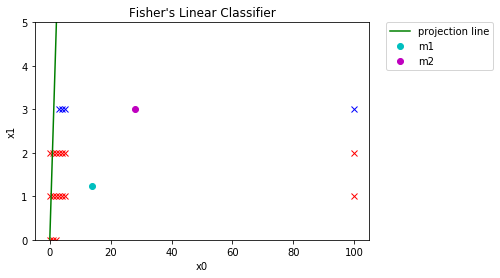

In [235]:
def visualize_fisher_boundry(fisher_w, x0_min=0, x0_max=100, color='r', label='projection line'):
    x10 = (-fisher_w[0]/fisher_w[1])*x0_min
    x11 = (-fisher_w[0]/fisher_w[1])*x0_max
    
    plt.plot([x0_min, x0_max], [x10, x11], color, label=label) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.ylim((0,5))
    
def visualize_fisher():
    visualize_data(fisher_data[0], fisher_data[1])
    visualize_fisher_boundry(fisher_weights, color='g')
    
    # visualize m1 and m2
    dim = c1_data.shape[1]
    m1 = np.average(c1_data, axis=0).reshape((dim, ))
    plt.plot([m1[0]], [m1[1]], 'co', label='m1')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    m2 = np.average(c2_data, axis=0).reshape((dim, ))
    plt.plot([m2[0]], [m2[1]], 'mo', label='m2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.title('Fisher\'s Linear Classifier')

visualize_fisher()

## Perceptron Algorithm

Compute the linear classifier based on the training data using the perceptron algorithm, starting with the initial parameter ($w_0 , w_1 , w_2$) = (1.5, 0, 0). For each iteration, you need to specify (a) the iteration number, (b) the current parameters, (c) the misclassified input x_n used in that particular iteration of stochastic gradient descent, and (d) the
updating vector. When the algorithm converges, plot the classification together with the training data.

### Calcualte the weights
- Minimize the error function (Perceptron Criterion): $E_P(w) = \sum_{n \in M}{w^T \phi_n t_n}$
- x in C1 if $w^T\phi(x) > 0$, and in C2 otherwise 
- Use stochastic gradient descent algorithm: $w^{(t+1)}=w^{(t)} - \eta\nabla E_p(w) = w^{(t)} + \eta \phi_n t_n$
- If the pattern is correctly classified, then the weight vector remains unchanged, whereas if it is incorrectly classified, then for class C1 we add the vector $\phi(x_n)$ onto the current estimate of weight vector w while for class C2 we subtract the vector $\phi(x_n)$ from w.

In [259]:
def w_calc_perceptron(x_train_with_bias, y_train, learning_rate = 0.1):
    dim = x_train_with_bias.shape[1]
    n_data = x_train_with_bias.shape[0]
    weights = np.array([1.5, 0, 0])
    
    is_converged = False
    i = 0
    while i < 1000000 and not is_converged:
        
        print('Iteration: ', i+1)
        print('Weights: \n', weights)
        i += 1
        
        is_converged = True
        misclassified_data = []
        misclassified_label = []
        
        # do stochastic gradient descent
        misclassified_data = np.array(misclassified_data)
        misclassified_label = np.array(misclassified_label)
        weights = weights + learning_rate*np.sum(np.multiply(misclassified_data.T, misclassified_label).T, axis=0)
        
        # test if converged
        for j in range(0, n_data):
            input_data = x_train_with_bias[j]
            if np.dot(input_data, weights)*y_train[j] < 0:
                is_converged = False
                misclassified_data.append(input_data)
                misclassified_label.append(y_train[j])
    
    return weights

def solve_perceptron():
    x_train_with_bias = perceptron_data[0]
    y_train = perceptron_data[1]
    
    perceptron_weights = w_calc_perceptron(x_train_with_bias, y_train)
    return perceptron_weights
    
perceptron_weights = solve_perceptron()
    

Iteration:  1
(4, 3)
(4,)
Iteration:  2
(16, 3)
(16,)
Iteration:  3
(4, 3)
(4,)
Iteration:  4
(4, 3)
(4,)
Iteration:  5
(15, 3)
(15,)
Iteration:  6
(4, 3)
(4,)
Iteration:  7
(4, 3)
(4,)
Iteration:  8
(15, 3)
(15,)
Iteration:  9
(4, 3)
(4,)
Iteration:  10
(4, 3)
(4,)
Iteration:  11
(15, 3)
(15,)
Iteration:  12
(4, 3)
(4,)
Iteration:  13
(4, 3)
(4,)
Iteration:  14
(15, 3)
(15,)
Iteration:  15
(4, 3)
(4,)
Iteration:  16
(4, 3)
(4,)
Iteration:  17
(15, 3)
(15,)
Iteration:  18
(4, 3)
(4,)
Iteration:  19
(4, 3)
(4,)
Iteration:  20
(15, 3)
(15,)
Iteration:  21
(4, 3)
(4,)
Iteration:  22
(4, 3)
(4,)
Iteration:  23
(14, 3)
(14,)
Iteration:  24
(4, 3)
(4,)
Iteration:  25
(4, 3)
(4,)
Iteration:  26
(14, 3)
(14,)
Iteration:  27
(4, 3)
(4,)
Iteration:  28
(4, 3)
(4,)
Iteration:  29
(13, 3)
(13,)
Iteration:  30
(4, 3)
(4,)
Iteration:  31
(4, 3)
(4,)
Iteration:  32
(13, 3)
(13,)
Iteration:  33
(4, 3)
(4,)
Iteration:  34
(4, 3)
(4,)
Iteration:  35
(12, 3)
(12,)
Iteration:  36
(4, 3)
(4,)
Iteration:  3

(3,)
Iteration:  344
(8, 3)
(8,)
Iteration:  345
(4, 3)
(4,)
Iteration:  346
(3, 3)
(3,)
Iteration:  347
(8, 3)
(8,)
Iteration:  348
(4, 3)
(4,)
Iteration:  349
(3, 3)
(3,)
Iteration:  350
(9, 3)
(9,)
Iteration:  351
(4, 3)
(4,)
Iteration:  352
(2, 3)
(2,)
Iteration:  353
(8, 3)
(8,)
Iteration:  354
(4, 3)
(4,)
Iteration:  355
(3, 3)
(3,)
Iteration:  356
(8, 3)
(8,)
Iteration:  357
(4, 3)
(4,)
Iteration:  358
(3, 3)
(3,)
Iteration:  359
(9, 3)
(9,)
Iteration:  360
(4, 3)
(4,)
Iteration:  361
(2, 3)
(2,)
Iteration:  362
(8, 3)
(8,)
Iteration:  363
(4, 3)
(4,)
Iteration:  364
(3, 3)
(3,)
Iteration:  365
(8, 3)
(8,)
Iteration:  366
(4, 3)
(4,)
Iteration:  367
(3, 3)
(3,)
Iteration:  368
(9, 3)
(9,)
Iteration:  369
(4, 3)
(4,)
Iteration:  370
(2, 3)
(2,)
Iteration:  371
(8, 3)
(8,)
Iteration:  372
(4, 3)
(4,)
Iteration:  373
(3, 3)
(3,)
Iteration:  374
(8, 3)
(8,)
Iteration:  375
(4, 3)
(4,)
Iteration:  376
(2, 3)
(2,)
Iteration:  377
(9, 3)
(9,)
Iteration:  378
(4, 3)
(4,)
Iteration:  379

(1, 3)
(1,)
Iteration:  719
(8, 3)
(8,)
Iteration:  720
(4, 3)
(4,)
Iteration:  721
(2, 3)
(2,)
Iteration:  722
(8, 3)
(8,)
Iteration:  723
(4, 3)
(4,)
Iteration:  724
(1, 3)
(1,)
Iteration:  725
(8, 3)
(8,)
Iteration:  726
(4, 3)
(4,)
Iteration:  727
(2, 3)
(2,)
Iteration:  728
(8, 3)
(8,)
Iteration:  729
(4, 3)
(4,)
Iteration:  730
(1, 3)
(1,)
Iteration:  731
(8, 3)
(8,)
Iteration:  732
(4, 3)
(4,)
Iteration:  733
(2, 3)
(2,)
Iteration:  734
(8, 3)
(8,)
Iteration:  735
(4, 3)
(4,)
Iteration:  736
(2, 3)
(2,)
Iteration:  737
(8, 3)
(8,)
Iteration:  738
(4, 3)
(4,)
Iteration:  739
(2, 3)
(2,)
Iteration:  740
(8, 3)
(8,)
Iteration:  741
(4, 3)
(4,)
Iteration:  742
(2, 3)
(2,)
Iteration:  743
(8, 3)
(8,)
Iteration:  744
(4, 3)
(4,)
Iteration:  745
(2, 3)
(2,)
Iteration:  746
(8, 3)
(8,)
Iteration:  747
(4, 3)
(4,)
Iteration:  748
(2, 3)
(2,)
Iteration:  749
(8, 3)
(8,)
Iteration:  750
(4, 3)
(4,)
Iteration:  751
(1, 3)
(1,)
Iteration:  752
(8, 3)
(8,)
Iteration:  753
(4, 3)
(4,)
Iteratio

### Visualize the Results (Perceptron)

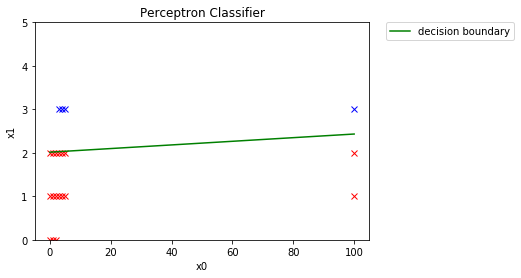

In [255]:
def visualize_perceptron_boundry(perceptron_weights, x0_min=0, x0_max=100, color='r', label='decision boundary'):
    # the decision boundary is w0 + w1*x0 + w2*x1 = 0
    # that is x1 = (-w1/w2)*x0 + (-w0/w2)
    x10 = (-perceptron_weights[1]/perceptron_weights[2])*x0_min + (-perceptron_weights[0]/perceptron_weights[2])
    x11 = (-perceptron_weights[1]/perceptron_weights[2])*x0_max + (-perceptron_weights[0]/perceptron_weights[2])
    
    plt.plot([x0_min, x0_max], [x10, x11], color, label=label) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.ylim((0,5))

def visualize_perceptron():
    visualize_data(perceptron_data[0], perceptron_data[1])
    visualize_perceptron_boundry(perceptron_weights, color='g')
    plt.title('Perceptron Classifier')
    
visualize_perceptron()